In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output
from dataclasses import dataclass, field
from typing import List, Dict, Optional

NUM_NODES = 30
CONNECTION_RADIUS = 0.25
NUM_AGENTS = 5
STARTING_BALANCE = 1000
FUEL_PRICE = 2.0
PAYOUT_MULTIPLIER = 5.0
BATTERY_CAPACITY = 100
CRITICAL_BATTERY = 25

@dataclass
class Order:
    id: str
    target_node: int
    weight_kg: int
    payout: float
    status: str = "pending"

class AgenticTruck:
    def __init__(self, agent_id, start_node, graph, capacity=100):
        self.id = agent_id
        self.current_node = start_node
        self.graph = graph
        self.battery = BATTERY_CAPACITY
        self.balance = STARTING_BALANCE
        self.capacity = capacity
        self.state = "IDLE"
        self.path: List[int] = []
        self.current_order: Optional[Order] = None
        self.target_node: int = start_node

In [ ]:
    def get_path_cost(self, start, end):
        try:
            length = nx.shortest_path_length(self.graph, start, end, weight='weight')
            path = nx.shortest_path(self.graph, start, end, weight='weight')
            return length, path
        except nx.NetworkXNoPath:
            return float('inf'), []

    def find_nearest_charger(self):
        chargers = [n for n, attr in self.graph.nodes(data=True) if attr.get('type') == 'charger']
        best_charger = None
        min_dist = float('inf')
        best_path = []
        for charger in chargers:
            dist, path = self.get_path_cost(self.current_node, charger)
            if dist < min_dist:
                min_dist = dist
                best_charger = charger
                best_path = path
        return best_charger, best_path

    def calculate_bid(self, order):
        if order.weight_kg > self.capacity:
            return float('inf')
        if self.state != "IDLE" or self.battery < CRITICAL_BATTERY:
            return float('inf')
        dist_to_target, _ = self.get_path_cost(self.current_node, order.target_node)
        fuel_cost = dist_to_target * FUEL_PRICE
        expected_profit = order.payout - fuel_cost
        if expected_profit < 10:
            return float('inf')
        return dist_to_target

    def assign_order(self, order):
        self.current_order = order
        self.state = "MOVING"
        self.target_node = order.target_node
        _, self.path = self.get_path_cost(self.current_node, self.target_node)
        if self.path: self.path.pop(0)

    def go_charge(self):
        charger_node, path = self.find_nearest_charger()
        if charger_node is not None:
            self.state = "TO_CHARGER"
            self.target_node = charger_node
            self.path = path
            if self.path: self.path.pop(0)

In [ ]:
    def step(self):
        if self.state == "IDLE" and self.battery < CRITICAL_BATTERY:
            self.go_charge()

        if self.state == "CHARGING":
            self.battery += 10
            self.balance -= 5
            if self.battery >= 100:
                self.battery = 100
                self.state = "IDLE"
            return

        if self.path:
            next_node = self.path[0]
            edge_data = self.graph.get_edge_data(self.current_node, next_node)
            distance = edge_data['weight']
            self.current_node = next_node
            self.path.pop(0)
            self.battery -= (distance * 2)
            self.balance -= (distance * FUEL_PRICE)

            if not self.path:
                if self.state == "MOVING":
                    self.balance += self.current_order.payout
                    self.current_order.status = "completed"
                    self.current_order = None
                    self.state = "IDLE"
                elif self.state == "TO_CHARGER":
                    self.state = "CHARGING"

In [ ]:
class Simulation:
    def __init__(self):
        self.setup_graph()
        self.setup_agents()
        self.orders = []
        self.order_count = 0

    def setup_graph(self):
        self.G = nx.random_geometric_graph(NUM_NODES, CONNECTION_RADIUS)
        for (u, v) in self.G.edges():
            self.G.edges[u, v]['weight'] = random.uniform(1.0, 3.0)
        for i in self.G.nodes():
            r = random.random()
            if r < 0.15:
                self.G.nodes[i]['type'] = 'charger'
                self.G.nodes[i]['color'] = 'red'
            else:
                self.G.nodes[i]['type'] = 'house'
                self.G.nodes[i]['color'] = '#A0CBE2'

    def setup_agents(self):
        self.agents = []
        for i in range(NUM_AGENTS):
            start_node = random.randint(0, NUM_NODES-1)
            cap = random.choice([50, 100, 200])
            self.agents.append(AgenticTruck(i, start_node, self.G, capacity=cap))

    def generate_order(self):
        target = random.randint(0, NUM_NODES-1)
        weight = random.randint(10, 120)
        payout = random.randint(50, 200)
        order = Order(id=f"ORD-{self.order_count}", target_node=target, weight_kg=weight, payout=payout)
        self.orders.append(order)
        self.order_count += 1
        return order

    def run_market(self):
        for order in self.orders:
            if order.status == "pending":
                bids = {agent: agent.calculate_bid(order) for agent in self.agents}
                valid_bids = {k: v for k, v in bids.items() if v != float('inf')}
                if valid_bids:
                    winner = min(valid_bids, key=valid_bids.get)
                    winner.assign_order(order)
                    order.status = "assigned"

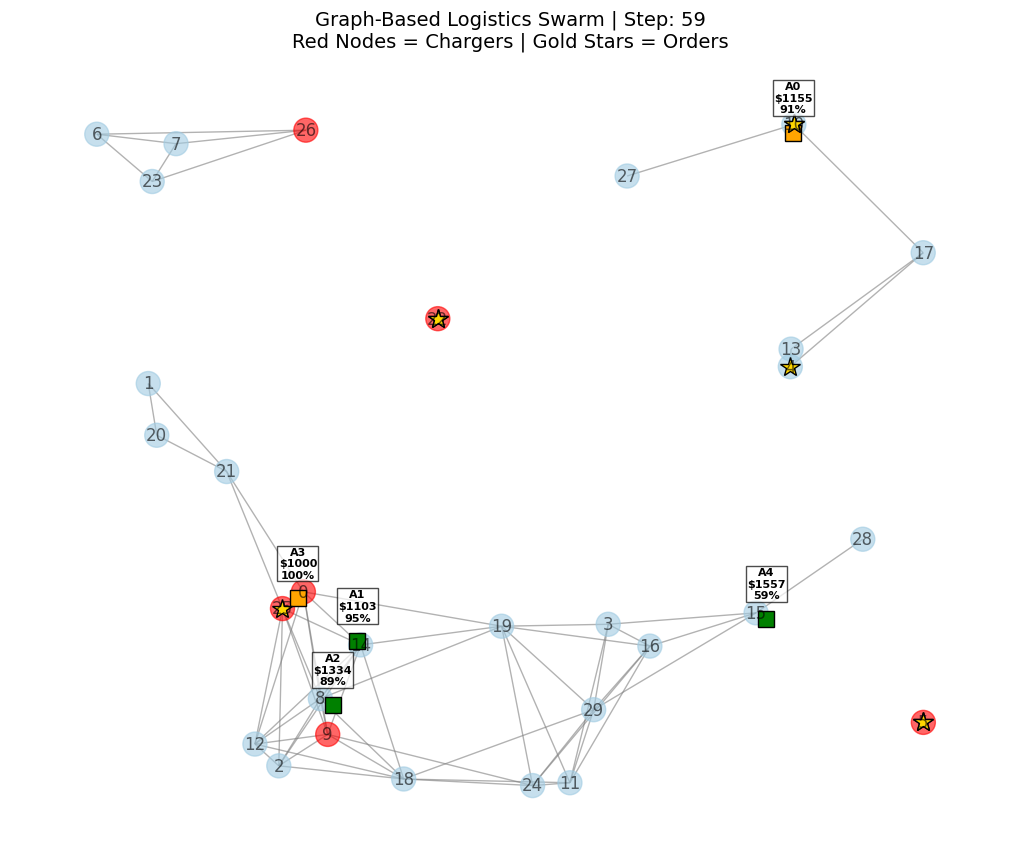

Simulation Finished.


In [2]:
    def step(self):
        if random.random() < 0.3:
            self.generate_order()
        self.run_market()
        for agent in self.agents:
            agent.step()

    def visualize(self, step_num):
        clear_output(wait=True)
        plt.figure(figsize=(10, 8))
        pos = nx.get_node_attributes(self.G, 'pos')
        node_colors = [self.G.nodes[n]['color'] for n in self.G.nodes()]
        nx.draw(self.G, pos, node_color=node_colors, with_labels=True, node_size=300, edge_color='gray', alpha=0.6)

        for agent in self.agents:
            x, y = pos[agent.current_node]
            jitter_x = x + random.uniform(-0.02, 0.02)
            jitter_y = y + random.uniform(-0.02, 0.02)
            color = 'green' if agent.state == "IDLE" else ('orange' if agent.state == "MOVING" else 'red')
            plt.plot(jitter_x, jitter_y, marker='s', markersize=12, color=color, markeredgecolor='black')
            plt.text(jitter_x, jitter_y+0.03, f"A{agent.id}\n${int(agent.balance)}\n{int(agent.battery)}%",
                     fontsize=8, ha='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

        for order in self.orders:
            if order.status in ["assigned", "pending"]:
                ox, oy = pos[order.target_node]
                plt.plot(ox, oy, marker='*', markersize=15, color='gold', markeredgecolor='black')

        plt.title(f"Graph-Based Logistics Swarm | Step: {step_num}\nRed Nodes = Chargers | Gold Stars = Orders", fontsize=14)
        plt.show()


print("Initializing Advanced Simulation...")
sim = Simulation()

for t in range(60):
    sim.step()
    sim.visualize(t)
    time.sleep(0.5)

print("Simulation Finished.")